## Imports 📦

In [1]:
import pandas as pd
import numpy as np
import emoji
import warnings
import nltk
from nltk.corpus import stopwords    
import string
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

## Load Data 💿

In [3]:
df = pd.read_csv("Data/cleaned_by_language.csv")

In [4]:
en_df = df[df['language'] == 'en']
es_df = df[df['language'] == 'es']

In [5]:
en_comment = en_df['text only'].to_list()
es_comment = es_df['text only'].to_list()
en_comment_with_emoji = en_df['text'].to_list()
es_comment_with_emoji = es_df['text'].to_list()

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))
es_stop_words = set(stopwords.words('spanish'))

def filter_comments(comment_list, stop_words):
    filtered_comments = []

    for comment in comment_list:
        # remove word starts with @
        comment = " ".join(filter(lambda x:x[0]!='@', comment.split()))
    
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # remove stopwords
        words = nltk.word_tokenize(comment)
        filtered_comment = [word for word in words if word.lower() not in stop_words]
        filtered_comment = ' '.join(filtered_comment)
        filtered_comment = comment
        filtered_comments.append(filtered_comment)
    return filtered_comments

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuhsinhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
en_filtered_comments = filter_comments(en_comment, en_stop_words)
es_filtered_comments = filter_comments(es_comment, es_stop_words)
en_with_emoji_filtered_comments = filter_comments(en_comment_with_emoji, en_stop_words)
es_with_emoji_filtered_comments = filter_comments(es_comment_with_emoji, es_stop_words)

## Text Embeddings using LASER - this pretrained model supports cross-lingual tasks and embeds in setence-level

In [8]:
pip install laserembeddings

Note: you may need to restart the kernel to use updated packages.


In [9]:
# run this in terminal first: python -m laserembeddings download-models
from laserembeddings import Laser

laser = Laser()
en_text_array = laser.embed_sentences(en_filtered_comments, lang='en')
es_text_array = laser.embed_sentences(es_filtered_comments, lang='es')
en_array = laser.embed_sentences(en_with_emoji_filtered_comments, lang='en')
es_array = laser.embed_sentences(es_with_emoji_filtered_comments, lang='es')

In [10]:
en_text_array.shape

(280, 1024)

## Emoji Embeddings using Emoji2Vec

In [11]:
from gensim.models import KeyedVectors

# Load pretrained emoji embeddings
emoji_model = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)

def emoji_embedding(df):
    emoji_list_list = df['emoji list'].to_list()

    # Initialize a list to store emoji embeddings
    emoji_embedding = []

    for emoji_list in emoji_list_list:
        emoji_list_embedding = []
        for emoji in emoji_list:
            try:
                emoji_list_embedding.append(emoji_model[emoji])
                
            except KeyError:
                pass

            # if len(emoji_list_embedding) != 0:
            # emoji_list_embedding = np.concatenate(emoji_list_embedding, axis=0)
        emoji_embedding.append(emoji_list_embedding)
    
    # average
    res = []
    for embeddings in emoji_embedding:
        average_embedding = np.mean(embeddings, axis=0)
        # padded arrays with zero emojis with a length 300 array filled with zeros
        if average_embedding is None or np.isnan(average_embedding).all():
            res.append(np.zeros(300))
        else:
            res.append(average_embedding)
    
    return np.array(res)

# en_max_size = max(len(arr) for arr in en_emoji_embedding)
# en_padded_arrays = [np.pad(arr, (0, en_max_size - len(arr)), 'constant') for arr in en_emoji_embedding]
# en_emoji_array = np.vstack(en_padded_arrays)

In [12]:
en_emoji_array = emoji_embedding(en_df)
es_emoji_array = emoji_embedding(es_df)

In [13]:
es_emoji_array.shape

(280, 300)

## Concatenate the text embeddings and emoji embeddings 

In [14]:
# Concatenate along columns (horizontally)
en_embeddings = np.concatenate((en_text_array, en_emoji_array), axis=1)
es_embeddings = np.concatenate((es_text_array, es_emoji_array), axis=1)

In [15]:
en_embeddings.shape

(280, 1324)

## Variable names 📇
- en_text_array: LASER embeddings on text only (shape:280x1024)
- en_emoji_array: emoji2vec embeddings on emoji only (shape: 280x300)
- en_embeddings: concatenate en_text_array and en_emoji_array (shape: 280, 1324)
- en_array: LASER embeddings on text+emoji (shape: 280x1024)
- (replace en by es to get result from Spanish dataset)

## Hierarchical Clustering 🪜

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_samples

def apply_hierarchical_clustering(lang_embeddings, lang_df):
    # method = 'single', 'complete', 'average' don't cluster well
    # ward is best for 
    linkage_matrix = linkage(lang_embeddings, method='ward')
    
    # Plotting dendrogram
    plt.figure(figsize=(24, 16))
    dendrogram(linkage_matrix, labels=lang_df['text'].tolist(), color_threshold=3, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Comments')
    plt.ylabel('Distance')
    plt.show()

    # can try different thresholds and criterion
    cluster_labels = fcluster(linkage_matrix, t=3, criterion='distance')

    silhouette_scores = silhouette_samples(lang_embeddings, cluster_labels)

    df_clusters = pd.DataFrame({
        "text": lang_df['text'],
        "cluster": cluster_labels,
        "silhouette_score": silhouette_scores
    })

    cluster_mean_silhouette = df_clusters.groupby('cluster')['silhouette_score'].mean().reset_index()
    df_clusters = df_clusters.merge(cluster_mean_silhouette, on='cluster', suffixes=('', '_mean'))

    return df_clusters, cluster_mean_silhouette, cluster_labels

In [17]:
from sklearn.manifold import TSNE
def visualize_clusters_tsne(embeddings, cluster_labels):
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title('Cluster Visualization - t-SNE Scatter Plot')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

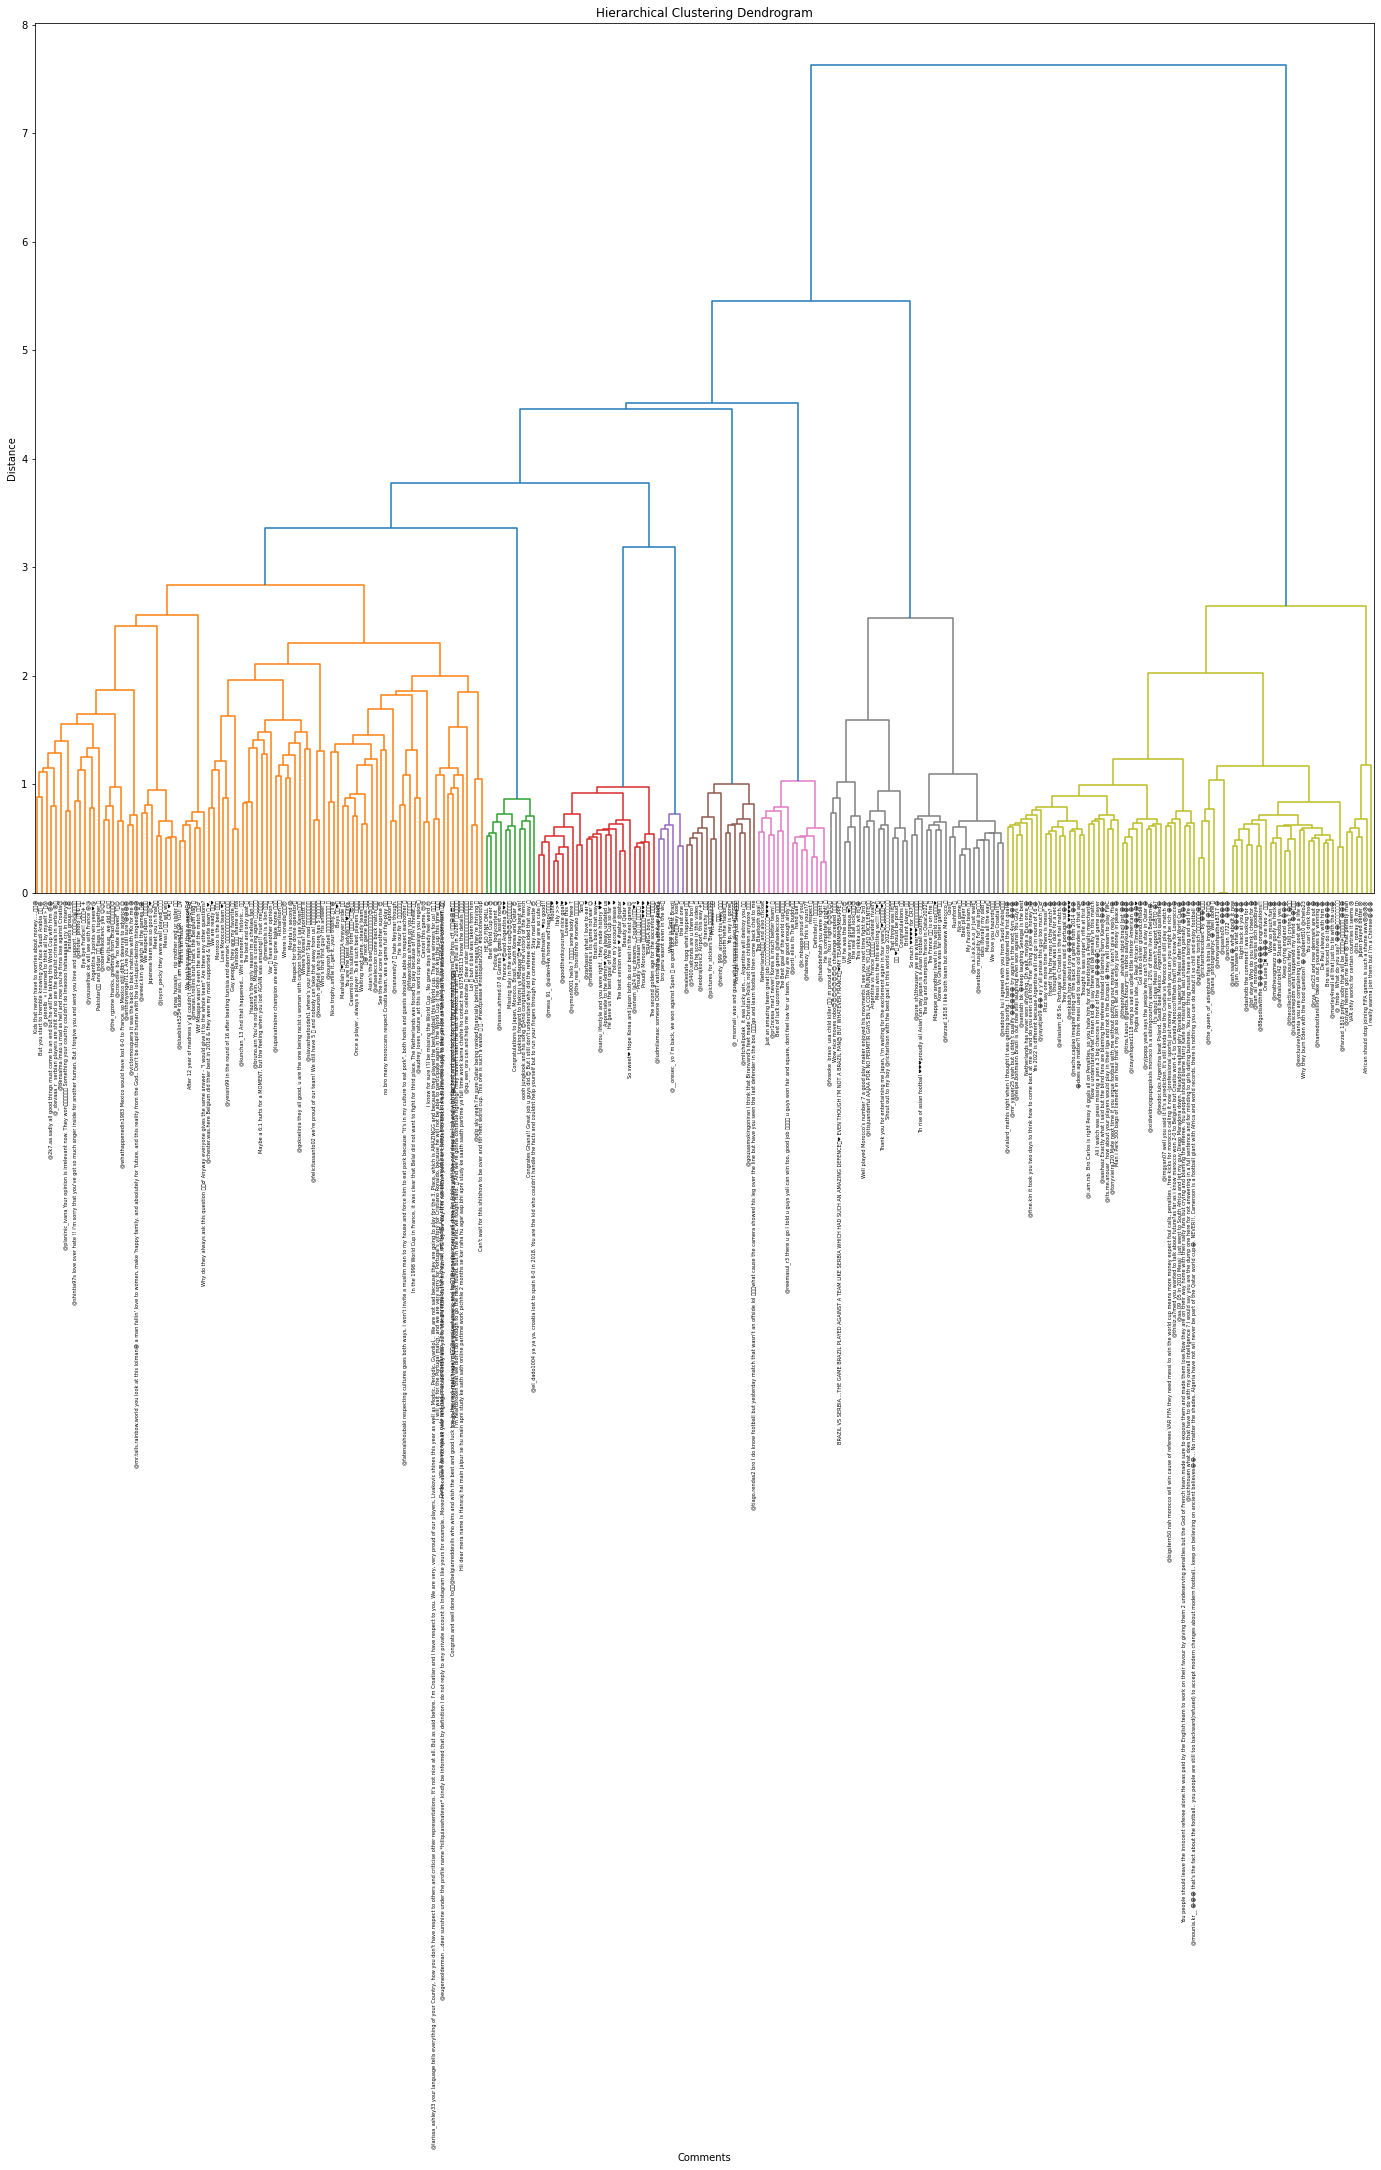

In [18]:
# Perform hierarchical clustering
en_linkage_matrix, en_mean_silhouette, en_cluster_labels = apply_hierarchical_clustering(en_embeddings, en_df)

## Cluster Labels: 😂, 🔥, 👏, 🤣, 💀, ❤️, 😍, Others

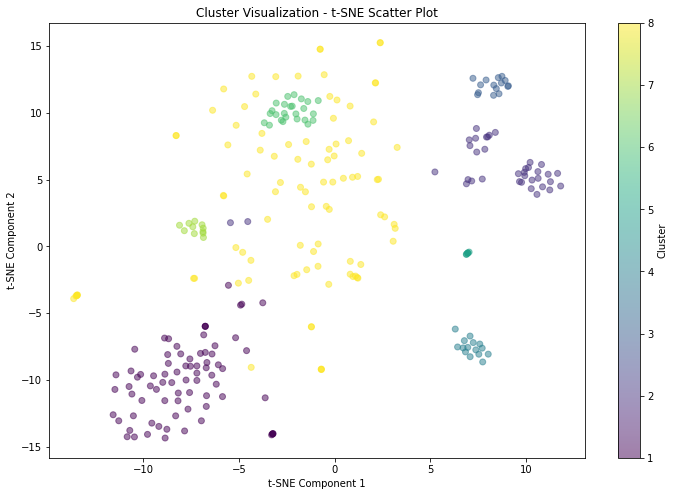

In [19]:
# Visualize clusters
visualize_clusters_tsne(en_embeddings, en_cluster_labels)

In [20]:
en_linkage_matrix

,text,cluster,silhouette_score,silhouette_score_mean
0,@xidiwldnxjqpspqpskxls morroco is a siblingcou...,1,0.374848,0.346112
1,@bf_steve Who do you think I cheer for 😂,1,0.412136,0.346112
2,@ryjpopp yeah says the people who can't Offord...,1,0.383771,0.346112
3,@matheusgmezz u are goofy as heck😂,1,0.422620,0.346112
4,@jan_schawe to what 😂😂😂😂😂,1,0.386759,0.346112
...,...,...,...,...
275,All out lets add new people\n\nWhere is Son?\n...,5,0.501797,0.498986
276,"@__oresec_ yo I’m back, we won against Spain 💀...",5,0.468551,0.498986
277,bro peru wasnt even in the wc💀,5,0.509701,0.498986
278,@ludmilamasc someone DIDNT watch the match. sh...,5,0.512258,0.498986


In [21]:
en_mean_silhouette

,cluster,silhouette_score
0,1,0.346112
1,2,0.224781
2,3,0.476288
3,4,0.417821
4,5,0.498986
5,6,0.485666
6,7,0.422899
7,8,-0.124502


In [22]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 8]['text'].tolist()

['We are ready 💛💙❤️',
 "Can't wait for this shitshow to be over and for next world cup. This one is such a waste 🗑 🙄. #nextplease #notoqatar2022 #boicotworldcup",
 'You are the best lady😻🤩🙏👏♥️⚽🤠fifa.',
 '@fatenalshoubaki respecting cultures goes both ways, i won\'t invite a muslim man to my house and force him to eat pork because "it\'s in my culture to eat pork", both hosts and guests should be able to respect eachother 👍',
 '👏😄 next game please..⚽🏃',
 '@glg_sky yeah I’m sure Qatar being ranked financially behind Greece means they’re thriving 🙄',
 'Fantastis group..✌😄',
 'Nice trophy..smile it..get it..your trophy..🏆✌😄',
 'Rainbow 🌈🌈🌈 shame on fifa',
 'Waiting next game..steady team⚽💥🏃',
 '@dhofar_photo 🏳️\u200d⚧️☪️🏳️\u200d🌈',
 'He is our Nr 1 🇨🇭👍👍🇨🇭',
 'no bro many moroccans respect Croatia team, was a game full of fair-play 👌🏽',
 'Congrats and well done to🇧🇪@belgianreddevils who wins and wish the best and good luck too in the next match against🇲🇦@equipedumaroc and for🇨🇦@canadasoccer

In [23]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 5]['text'].tolist()

['the last one 💀',
 'All out lets add new people\n\nWhere is Son?\nHome💀💀',
 '@__oresec_ yo I’m back, we won against Spain 💀 so good luck against Brazil',
 'bro peru wasnt even in the wc💀',
 '@ludmilamasc someone DIDNT watch the match. shut up bruh💀.',
 'They kost💀']

In [24]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 6]['text'].tolist()

['Son🥺',
 'TERANGA boys 🇸🇳🇸🇳❤️',
 '@goodthanksyourself nice goal❤️',
 '@smithswith_ ❤️so good!!',
 '@the_real_thorstinho #onetwo 🤭🤭🤭🤭🤭',
 'Beauty of Qatar ❤️',
 'Italy >>❤️',
 'Mount❤️',
 '@maidenles.s its game not war ☺️',
 'Follow m’y account please ❤️',
 'Proudly Ghanaian 🇬🇭 🇬🇭 🇬🇭 🇬🇭 🇬🇭 ❤️',
 '@zarbassir what I love to ear ❤️',
 'The best version ever ❤️ #qatar @qatar',
 'The second golden age for the socceroos 🇦🇺🟡🟢',
 'Loveee this ❤️',
 'He gave us the best goal of the World Cup so far ❤️',
 'So sweet❤️ Hope Korea and Japan both do our best in the next game☺️',
 '@sonam_la24 in ur dreams... Croatia!!!🇭🇷❤️✌️',
 'Brazils back that way⬅️',
 '@symon9001 hello ? 🤟🏽🇦🇷 some body here ?',
 '@mess_91_ @aiden44w home and happy🥳🥳🤌🏻',
 'Proudly Moroccan 🇲🇦🇲🇦🇲🇦🇲🇦❤️❤️❤️❤️',
 'Appreciate to the Admin❤️ who always updated us',
 '@sarou_lifestyle and you were right , they made history ♥️♥️',
 'They are so cute \U0001f979\U0001f979']

In [25]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 2]['text'].tolist()

['@itisjuanderful AAJAA POR NO PERMITIR GAYS EN LA COPA MUNDIAL YO LO VEO EXCELENTE👏🔥',
 'This nikka sick wit it🔥😂',
 'We love you hazards🔥🔥🔥',
 'The France 🇫🇷 is on Fire 🔥',
 'Wow nice moves robo😍😍😍😍😍😍😍😍 challenge accepted 🔥🔥🔥🔥',
 'dats literally my dad 🔥',
 'Best player 🔥🔥',
 '@pure_sh1thousery we are winer❤️❤️🔥🇮🇷🇮🇷🇮🇷🇮🇷',
 'Brilliant player 👏🔥',
 'My Favorite team 🔥🔥',
 '@fxwoke  bravo  usa child killer 👏👏i m proud of you . You r right 😍😍😍😉🙃',
 '@nadoosh_ku I agreed with you from Saudi Arabia🔥🔥🔥',
 'Shout out to my boy @richarlison with the best goal in this world cup 2022👏🔥🇧🇷🇧🇷🇧🇷🇧🇷',
 'Korea Vs Ghana was far better game 🔥🔥',
 'Musiala all the way🔥',
 'Rushford 🔥',
 "BRAZIL VS SERBIA....THE GAME BRAZIL PLAYED AGAINST A TEAM LIKE SERBIA WHICH HAD SUCH AN AMAZING DEFENCE🔥❤️ EVEN THOUGH I'M NOT A BRAZIL FAN😍 BUT WHATEVER FRANCE🔥❤️MY TEAMMMM😍MBAPPE 💗",
 'Nice game 🔥',
 '@beatbox_musicality For real bro🔥🔥🔥',
 '🇹🇳 ❤️🔥 should be proud 👏',
 'Wow very gorgeous ❤️🔥😍',
 'the real blue lock🙌🔥🔥😍'

In [26]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 1]['text'].tolist()

['@xidiwldnxjqpspqpskxls morroco is a siblingcountry aswell. 20% of them live in Belgium😂.',
 '@bf_steve Who do you think I cheer for 😂',
 "@ryjpopp yeah says the people who can't Offord a stay in Qatar 😂",
 '@matheusgmezz u are goofy as heck😂',
 '@jan_schawe to what 😂😂😂😂😂',
 'Yes 2022 is different because Argentina will not go in round of 16 😂',
 '@dashotb the comment I was looking for 😂',
 'One Love 🌈✖ 😂😂😂 one two ✔ 🤭🤭🤭',
 'Why they burn Eden with the food question? 😂 @albert810 @chelo23',
 '@exclusivelysania you are complaining in every post get a life 😂',
 '@afdhalulrizki42 😂 Stupid Football yes 😂',
 '@the_queen_of_adventure Haya bina ila lmondial 😂🇨🇲😍',
 'Bro was forced to do it😂😂😂😂😂',
 '@iuchinouen what does that have to do with my overall intelligence ? I would say you are the dump one here for not answering in a full sentence and for minding to girls dating business. You poor thing musst have a boring and sad life 😂',
 "@mounia.kr__ 😂😂😂 that's the fact about the football.. you 

In [27]:
en_linkage_matrix[en_linkage_matrix['cluster'] == 4]['text'].tolist()

["@tiago.rendas2 bro I do know football but yesterday match that wasn't an offside lol 🤣🤣🤣what cause the camera showed his leg over the line but have you seen the last defender in the box 🤣🤣🤣go and learn football then come back chat to me",
 '@_francechy_ 🤣🤣🤣',
 '@5400.seconds are u there bro? 🤣',
 "@gousasmokingoniran I think that Biranvand's feet made Christian Polsic not have children anymore 🤣🤣🤣",
 '@realestate_topg what happened 🤣🤣',
 '@mitchellpolak  it was lucky win.... Argentine will destroy you 🤣🤣',
 'Priceless!! 🇨🇲\n🤣🤣🤣',
 'Did he score in this video 🤣',
 'Portugal humiliated you Shaq🤣🤣🤣\n￼',
 '@pictures_for_stickers Brazil 🇧🇷🛫🏠🤣🤣🤣🤣',
 'Yep, ney is gone🤣',
 '@goborm hehe Habibi🤣🤣',
 '@leobrajkovic2 Airport, this way ✈️🤣',
 '@twinty_999  airport this way 🤣👍🏻',
 '@_msomali_wao and guess what morocco also lost🤣🤣🤣🤣🤣🤣']

## Spanish

In [28]:
pip install googletrans==4.0.0-rc1

Note: you may need to restart the kernel to use updated packages.


In [29]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Function to translate a text
def translate_text(text, target_language='en'):
    try:
        translation = translator.translate(text, dest=target_language)
        return translation.text
    except Exception as e:
        return str(e)

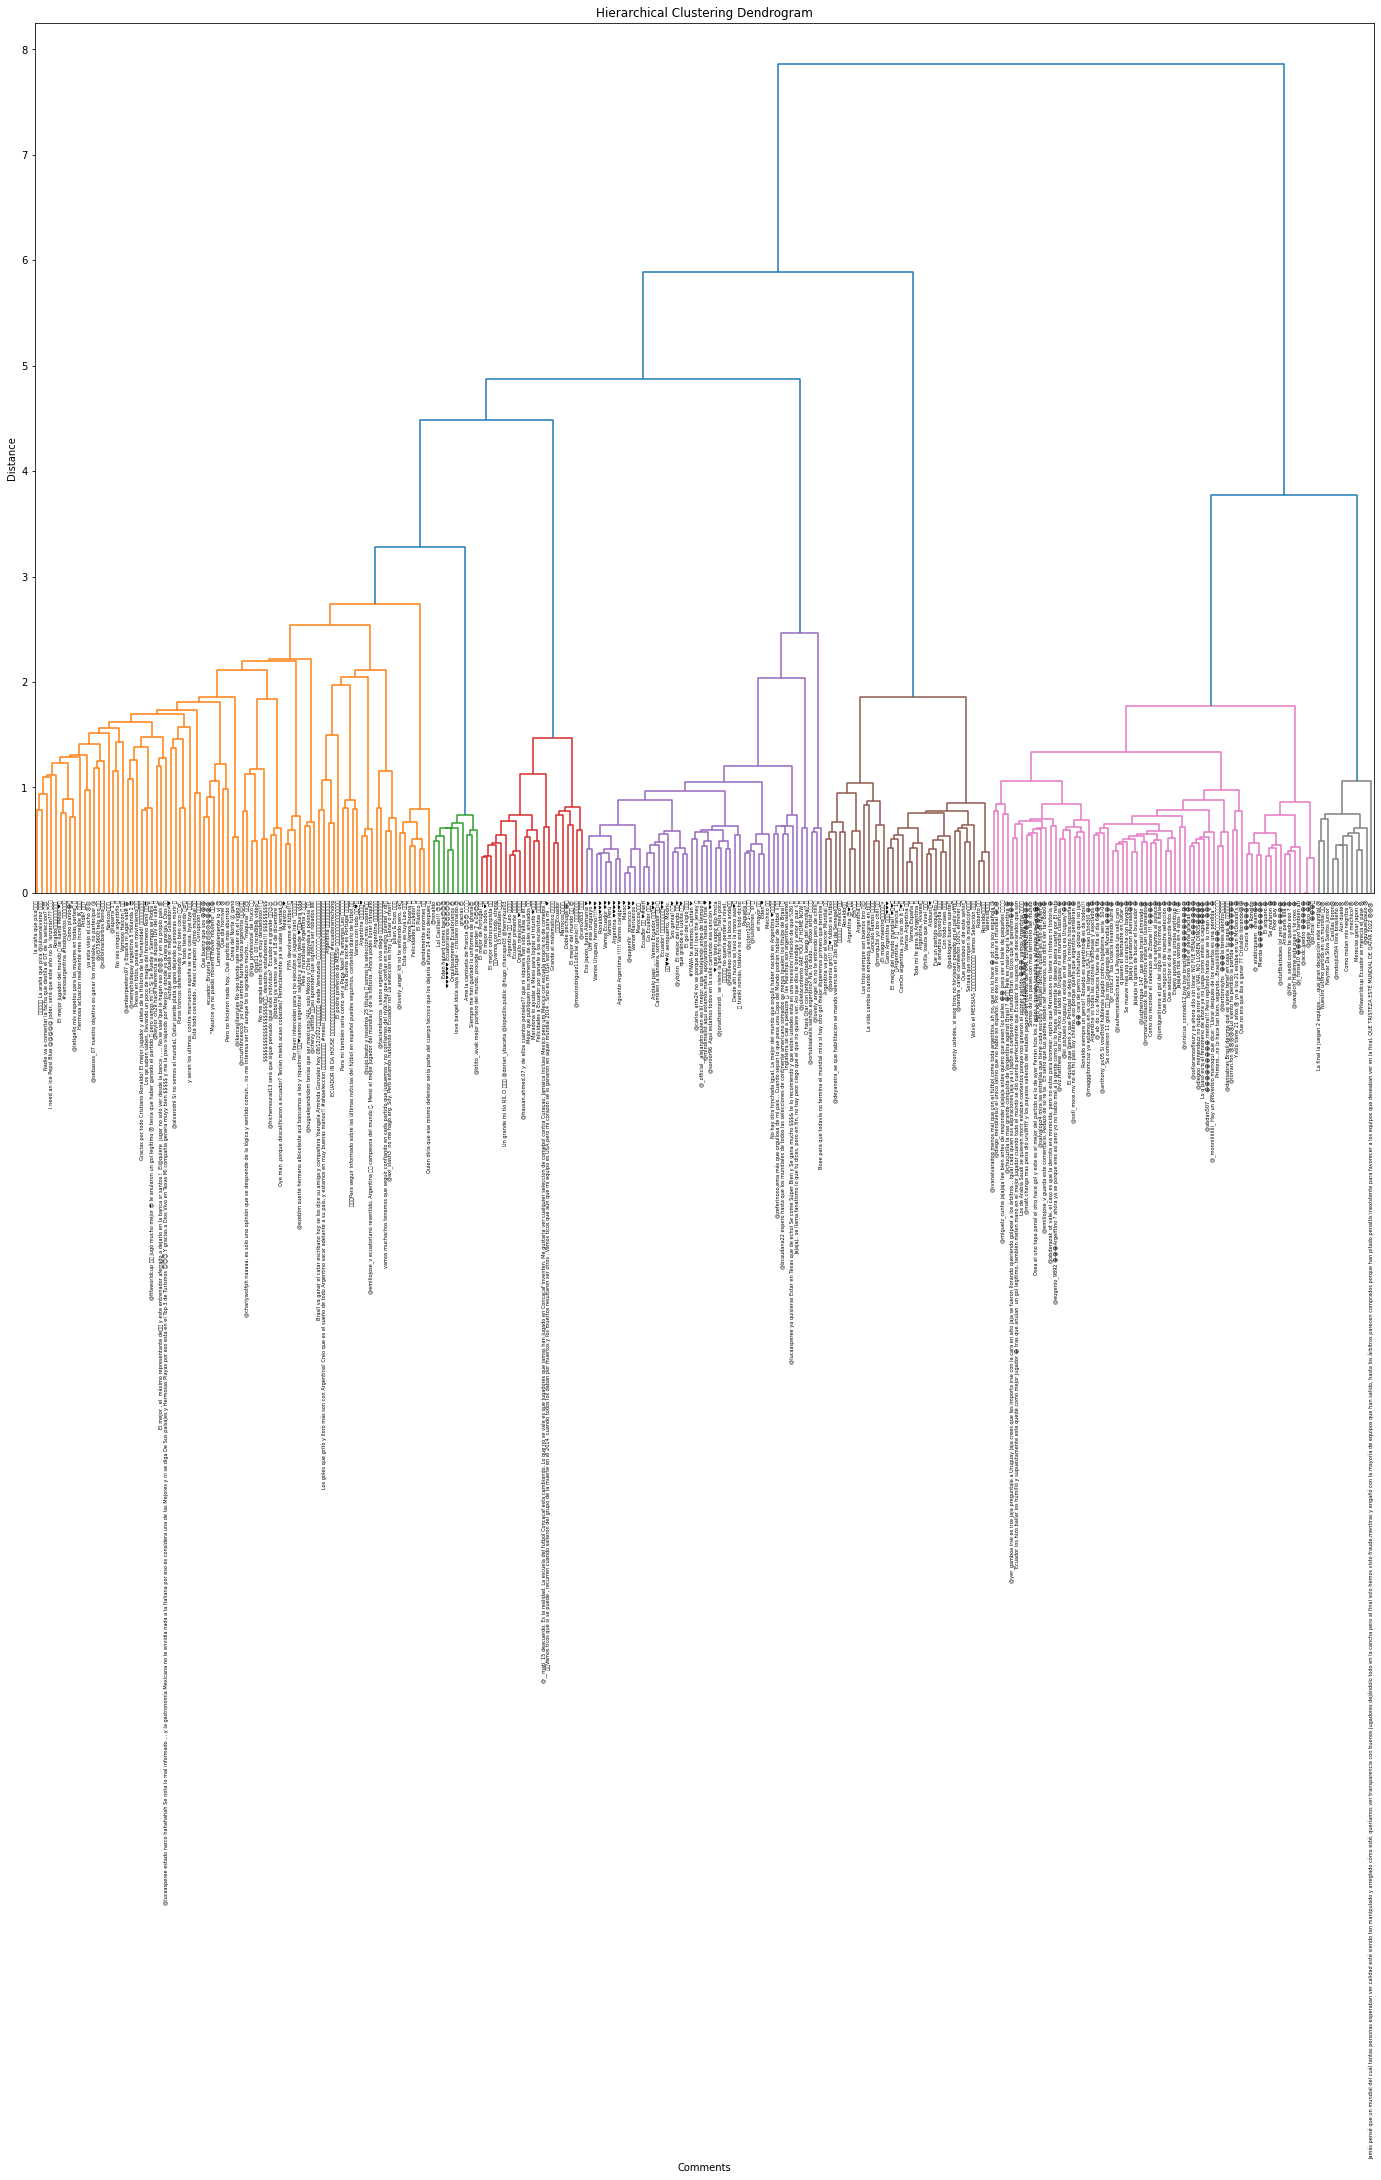

In [30]:
es_linkage_matrix, es_mean_silhouette, es_cluster_labels = apply_hierarchical_clustering(es_embeddings, es_df)

## Cluster Labels: 😢, 😂, 🔥, ❤️, 👏, 😍, Others

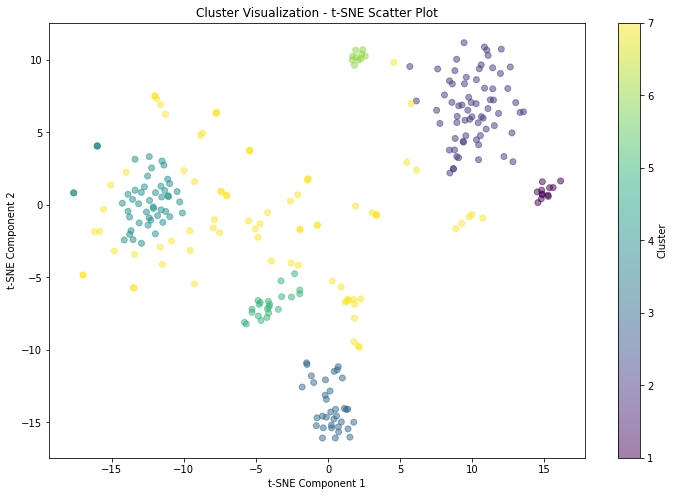

In [31]:
visualize_clusters_tsne(es_embeddings, es_cluster_labels)

In [32]:
es_linkage_matrix['translated_text'] = es_linkage_matrix['text'].apply(translate_text, target_language='en')

In [33]:
es_linkage_matrix

,text,cluster,silhouette_score,silhouette_score_mean,translated_text
0,Orgullosamente Ecuatorianos 😍,6,0.502996,0.468130,Proudly Ecuadorians 😍
1,❤️❤️❤️❤️❤️❤️ Ecuatorianos 😍😍😍😍😍,6,0.492119,0.468130,❤️❤️❤️ located Ecuadorians 😍😍😍😍😍
2,"@btito_.avak mejor portero del mundo, procede ...",6,0.443004,0.468130,"@Btito_.Avak Best goalkeeper in the world, pro..."
3,Eden hazard comes back😍😍😍,6,0.480451,0.468130,Eden hazard comes back😍😍😍
4,love banget idola saya portugal - cristiano ro...,6,0.451412,0.468130,I really love my idol Portugal - Cristiano Ron...
...,...,...,...,...,...
275,Neymar Da Silva Santos Junior 😢,1,0.380810,0.428671,Neymar da Silva Santos Junior 😢
276,@mdsojid364 llora brasileño 😢,1,0.489586,0.428671,@mdsojid364 cries Brazilian 😢
277,Casillas lloron😢,1,0.487015,0.428671,Casillas Lloron😢
278,Jamás pensé que un mundial del cuál tantas per...,1,0.259818,0.428671,I never thought that a World Cup from which so...


In [34]:
es_mean_silhouette

,cluster,silhouette_score
0,1,0.428671
1,2,0.379912
2,3,0.388194
3,4,0.413665
4,5,0.394112
5,6,0.468130
6,7,-0.103273


In [35]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 6]['translated_text'].tolist()

['Proudly Ecuadorians 😍',
 '❤️❤️❤️ located Ecuadorians 😍😍😍😍😍',
 '@Btito_.Avak Best goalkeeper in the world, proceeds to lose 7 to 0😍😍😍',
 'Eden hazard comes back😍😍😍',
 'I really love my idol Portugal - Cristiano Ronaldo.😍',
 "I have always liked Ghana's uniforms😍",
 'Love the France shirt 😍😍😍 🇺🇾🇨🇵',
 'Lol Casillas!!! 😍😍',
 'gracias 😍',
 '😍ronaldo']

In [36]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 1]['translated_text'].tolist()

['Our last game in a World Cup 🇨🇴😢',
 'How are my blacks shit 😢',
 '@fifaworldcup Ecuador deserved the pass 😢',
 'It still hurts',
 'and mechico? 😢',
 '@guiguelpaulo 😢',
 'You deserved to win Japon 😢',
 'Neymar da Silva Santos Junior 😢',
 '@mdsojid364 cries Brazilian 😢',
 'Casillas Lloron😢',
 'I never thought that a World Cup from which so many people expected to see quality is being so manipulated and fixed how it is, we wantedOut, even the referees seem bought because they have been a non -existent penalty to favor the teams they wanted to see in the final, how sad is the world of Qatar 2022 😢😢😢.',
 'The final is played by 2 teams ...... What great disappointment this World Cup 😢']

In [37]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 4]['translated_text'].tolist()

["@Carlos_Arte24 I don't know why but i love the jersey 🥶",
 'Ecuador! 🇪🇨🇪🇨🇪🇨🇪🇨❤❤',
 'Change the flag, we are Ecuador 🇪🇨☝🏻',
 '@ Jctorr130 1-1🤫🤫🤫🤫',
 'Go Ecuador 🇪🇨❤️',
 '🤫 traki just, everything is still said',
 "Let's go Peru ❤️",
 "Let's go Ecuador ❤️❤️",
 "Let's go Morocco ❤️",
 'Eden ❤️',
 'Mechanic 🤏🏼',
 '@queenfir_ Morocco ❤️❤️',
 'Ufff that Uruguayan ❤️',
 'Anótalo Papi ..... Come Ecuador 🇪🇨🥰❤️❤️',
 '@mindimalist here we are mana, supporting them until the end ❤️',
 '_Marocoo🇲🇦🫀_',
 'The goal of the century 🇨🇷\U0001fae1',
 '@Zeferinooo.Ama more than proud of my country ... when they know what a World Cup weighs can talk about football ✌️🇺🇾',
 'From there the hand was washed AAA❤️\u200d🩹',
 '#Ynwa we love you Captain ❤️',
 'Ecuador 🇪🇨 ❤️#win',
 '@Luisitorres_ Yes 🥵',
 'That Japan, outside Germany ❤️',
 '@fabilleao Shock your mouth go',
 '@lucaasperee you would already want to be in Texas that Echol eats super good and you earn a lot $$$ & I recommend it and that you are in a rec

In [38]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 5]['translated_text'].tolist()

['👏👏We go with everything, Strong',
 '👏👏🙌🙌Ecuador',
 'Congratulations to Ecuador for winning the slaves 👏🏼👏🏼',
 '15 World Cups 👏👏👏',
 'The best of all ❤️👏',
 "We are thicerly that if one can, they turn to when they left the death group in 2014 when they all gave them for dead and the dead turned out to be others.Let's go even if my team is USA but my heart won it in that 2014 World Cup.But it is my USA are you for me.❤️",
 'Ecuador present 🇪🇨👏👏',
 'Maradona help Messi to achieve triumph ❤️👏👏👏',
 'The best in the world 👏🏻 😍',
 'The best in Portugal 👏👏',
 'Mexican pride ❤️👏🏻🇲🇽',
 'Better publish the moments of canceled goals 👏👏',
 '@caro2653 👏👏👏',
 'Great the mathematician',
 'A great my uncle Ril or 👏👏👏 @dorian_ybaceta @lopezillo.public @hugo_charcape03 @hanrykux03',
 'The best midfielder 👏🏻',
 'Double breast 😂👏',
 '@Maxirodriguez11Oficial genius !!!👏👏👏👏💙🤍💙',
 "@__ mati_15 agreement.It's reality.The Concacaf Soccer School is changing.What is not worth is that players who have never play

In [39]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 3]['translated_text'].tolist()

['With every teacher 🔥🇨🇷',
 'Ronaldo🙌🔥',
 'The master magician🔥🔥🤍👏🏻⚡',
 'We love you @yosoy8a 🇲🇽🔥',
 "Let's go Spain 🔥",
 'Life changes when it begins to focus on you🎶🔥',
 '@sandra_cariel camereron 100% 🔥🔥',
 '@hoonjy you, if those shots did not get stuck in the Uffff stick🔥',
 'It will be to break the curse🔥🔥🔥',
 'Valencia🔥🔥🔥',
 'All my faith for Argentina 🔥',
 '@Borenia Grs !!!🔥🙌❤️ Soccer is football',
 '@pablogavi good luck🔥',
 '@deyaneira_ae to enable Valencia in the 2nd goal of Senegal🙌🔥🔥',
 "Messias returned 🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷🇦🇷 Let's go selection 🔥🔥🔥",
 'Ronaldo🔥🔥🔥🔥',
 'Aidoun 🔥❤️',
 '@hilla_loaiza what level 🔥🔥🔥',
 "What's up the one of this lord🔥",
 'Argentina 🔥💚',
 'The trios are always good bro 🔥😉',
 '@marqu3si yo bro chill 👏🔥',
 'The best in the world!❤️\u200d🔥❤️\u200d🔥',
 '😍ñ🔥🔥🔥',
 'Goncalo Ramos 🔥🔥👏👏',
 'CommOn argentina..you can do it 🔥❤️🔥',
 'Come on Argentina 🔥🔥',
 'It was an exquisite party 🔥',
 'Gano Argentina 🔥🔥🔥❤️❤️❤️',
 '🔥🔥🔥👏🙌 mexico 🇲🇽',
 'Argentina goes for the third Wo

In [40]:
es_linkage_matrix[es_linkage_matrix['cluster'] == 7]['translated_text'].tolist()

["Let's go with everything 🇨🇷 ♥ ️⚽️",
 'Congratulations Ecuador!🙌',
 "@alvarodnl If we don't see the World Cup, Qatar loses money that won leaving people to die 🙃",
 'Corruption 💰💰💰💰',
 "@ikercasillasrules I don't see where Neuer comes out in the video 😮",
 'I need an Ice Pepsi Blue 😋😋😋😋😋 JODER, will it be that this year will not throw it ???🤔🤔🤔',
 "Let's go España 🙌",
 'The cucho is already old ☹☹',
 'But they did nothing today ... what a boring game 😒',
 "@bbsitaj we're going to see on December 18 😉",
 'Nobody is going to comment on the facade that distills the DT of the National Team?🌚😈',
 '@JL5759600 Telo Sico 🤫🤐',
 'VAMOOO HALCON 🦅 🇺🇾',
 'Hello good night is Portugal ⚽️👍🇵🇹',
 "@axl_sash3 I don't get arg.Am.But we are talking about Ecuador, right?The selection is today 💙 win or die.",
 '@Hichemourad13 Is this individual still thought about?Ecuador is great 🇪🇨😉😉',
 "@fifaWorldcup 🇪🇨 He played much better 😎 They canceled a legitimate goal 😠 I had to have won the game 👏 But let's go 🇪

# Interactive Clustering Scatterplot

In [41]:
pip install --upgrade plotly

Note: you may need to restart the kernel to use updated packages.


In [42]:
es_df['translated_text'] = es_df['text'].apply(translate_text, target_language='en')

en_emoji = []
for i in en_df['emoji list'].tolist():
    en_emoji.append(i[2])

es_emoji = []
for i in es_df['emoji list'].tolist():
    es_emoji.append(i[2])

In [43]:
import plotly.express as px
import plotly.subplots as sp

In [56]:
def plotly_combined_tsne(embeddings1, embeddings2, cluster_labels1, cluster_labels2, lang_df1, lang_df2, emoji1, emoji2):
    combined_embeddings = np.concatenate([embeddings1, embeddings2])

    tsne = TSNE(n_components=2, random_state=42)
    combined_embeddings_tsne = tsne.fit_transform(combined_embeddings)

    df1 = pd.DataFrame({'x': combined_embeddings_tsne[:len(embeddings1), 0],
                        'y': combined_embeddings_tsne[:len(embeddings1), 1],
                        'Cluster': cluster_labels1,
                        'Language': 'English',
                        'Text': lang_df1['text'],
                        'Emoji': emoji1})

    df2 = pd.DataFrame({'x': combined_embeddings_tsne[len(embeddings1):, 0],
                        'y': combined_embeddings_tsne[len(embeddings1):, 1],
                        'Cluster': cluster_labels2,
                        'Language': 'Spanish',
                        'Text': lang_df2['translated_text'],
                        'Emoji': emoji2})

    df_combined = pd.concat([df1, df2])

    # Plot the t-SNE scatter plot
    fig = px.scatter(df_combined, x='x', y='y', color='Language',
                     title='Combined t-SNE Scatter Plot',
                     labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'},
                     color_discrete_map={'English': 'blue', 'Spanish': 'orange'},
                     hover_data={'Text': True, 'Cluster': True, 'Language': True})
    
    fig.update_layout(height=600, width=800)
    fig.show(renderer='iframe')

plotly_combined_tsne(en_embeddings, es_embeddings, en_cluster_labels, es_cluster_labels, en_df, es_df, en_emoji, es_emoji)

In [57]:
def plotly_lang_tsne(embeddings1, embeddings2, cluster_labels1, cluster_labels2, lang_df1, lang_df2, emoji1, emoji2):
    combined_embeddings = np.concatenate([embeddings1, embeddings2])

    tsne = TSNE(n_components=2, random_state=42)
    combined_embeddings_tsne = tsne.fit_transform(combined_embeddings)

    df1 = pd.DataFrame({'x': combined_embeddings_tsne[:len(embeddings1), 0],
                        'y': combined_embeddings_tsne[:len(embeddings1), 1],
                        'Cluster': cluster_labels1,
                        'Language': 'English',
                        'Text': lang_df1['text'],
                        'Emoji': emoji1})

    df2 = pd.DataFrame({'x': combined_embeddings_tsne[len(embeddings1):, 0],
                        'y': combined_embeddings_tsne[len(embeddings1):, 1],
                        'Cluster': cluster_labels2,
                        'Language': 'Spanish',
                        'Text': lang_df2['translated_text'],
                        'Emoji': emoji2})

    fig1 = px.scatter(df1, x='x', y='y', text='Emoji',
                     title='English t-SNE Scatter Plot',
                     labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'},
                     hover_data={'Text': True, 'Cluster': True, 'Language': True})
        
    fig2 = px.scatter(df2, x='x', y='y', text='Emoji',
                     title='Spanish t-SNE Scatter Plot',
                     labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'},
                     hover_data={'Text': True, 'Cluster': True, 'Language': True})
    

    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['English t-SNE', 'Spanish t-SNE'],
                           shared_xaxes=False, shared_yaxes=False)

    fig.add_trace(fig1['data'][0], row=1, col=1)
    fig.add_trace(fig2['data'][0], row=1, col=2)
    fig.update_layout(height=600, width=1600, showlegend=False)
    fig.show(renderer='iframe')

plotly_lang_tsne(en_embeddings, es_embeddings, en_cluster_labels, es_cluster_labels, en_df, es_df, en_emoji, es_emoji)

## Rand Index

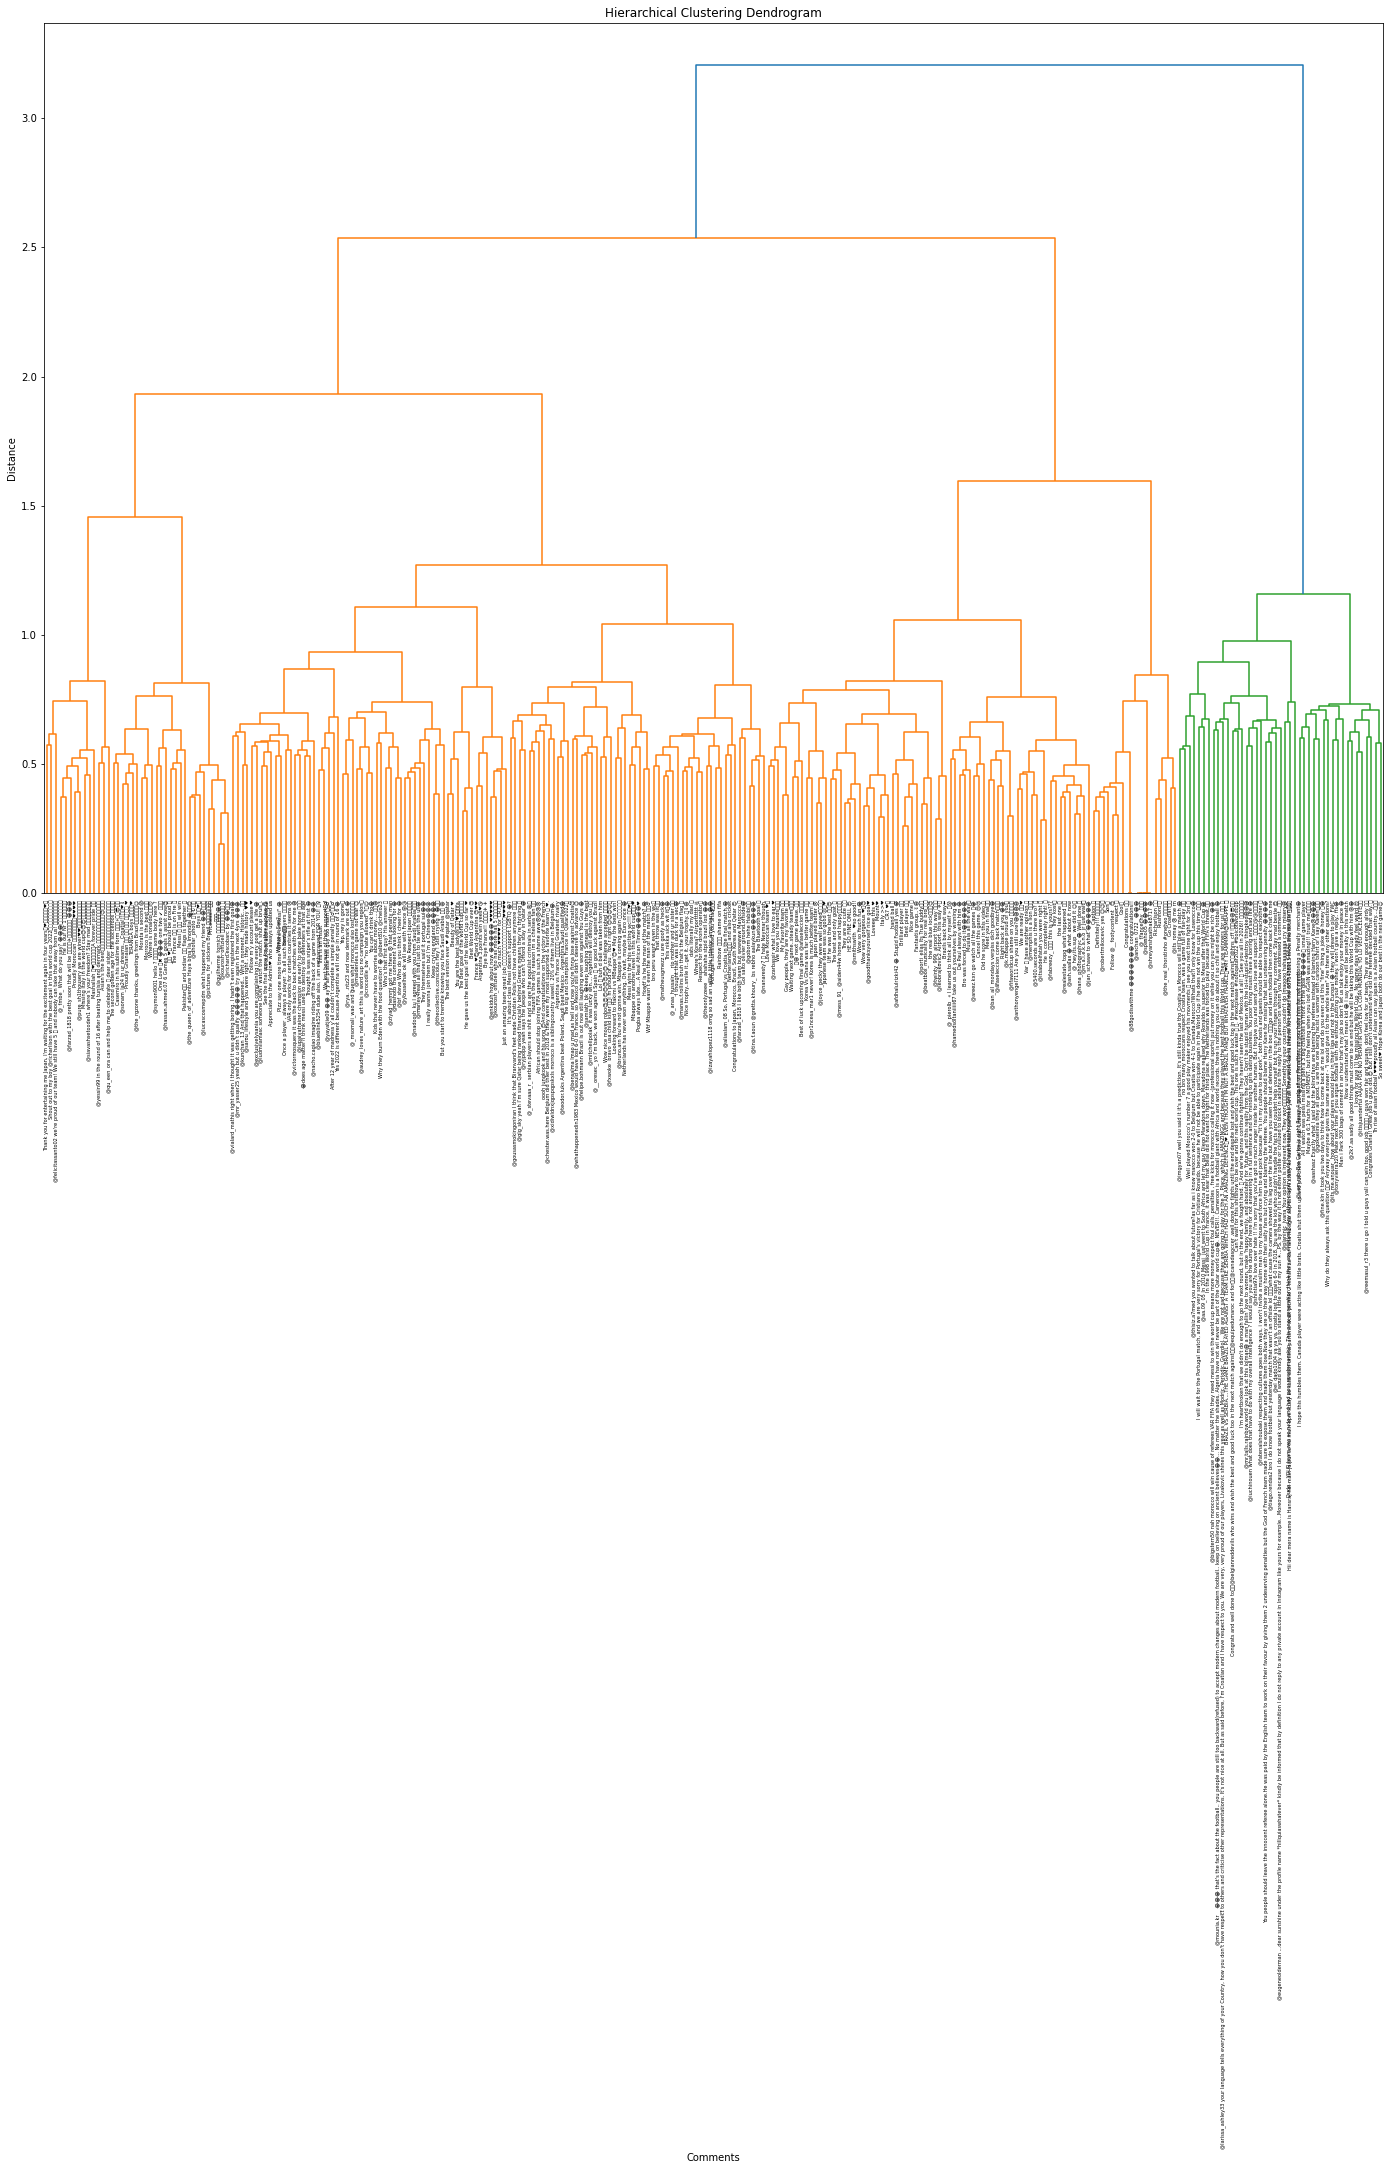

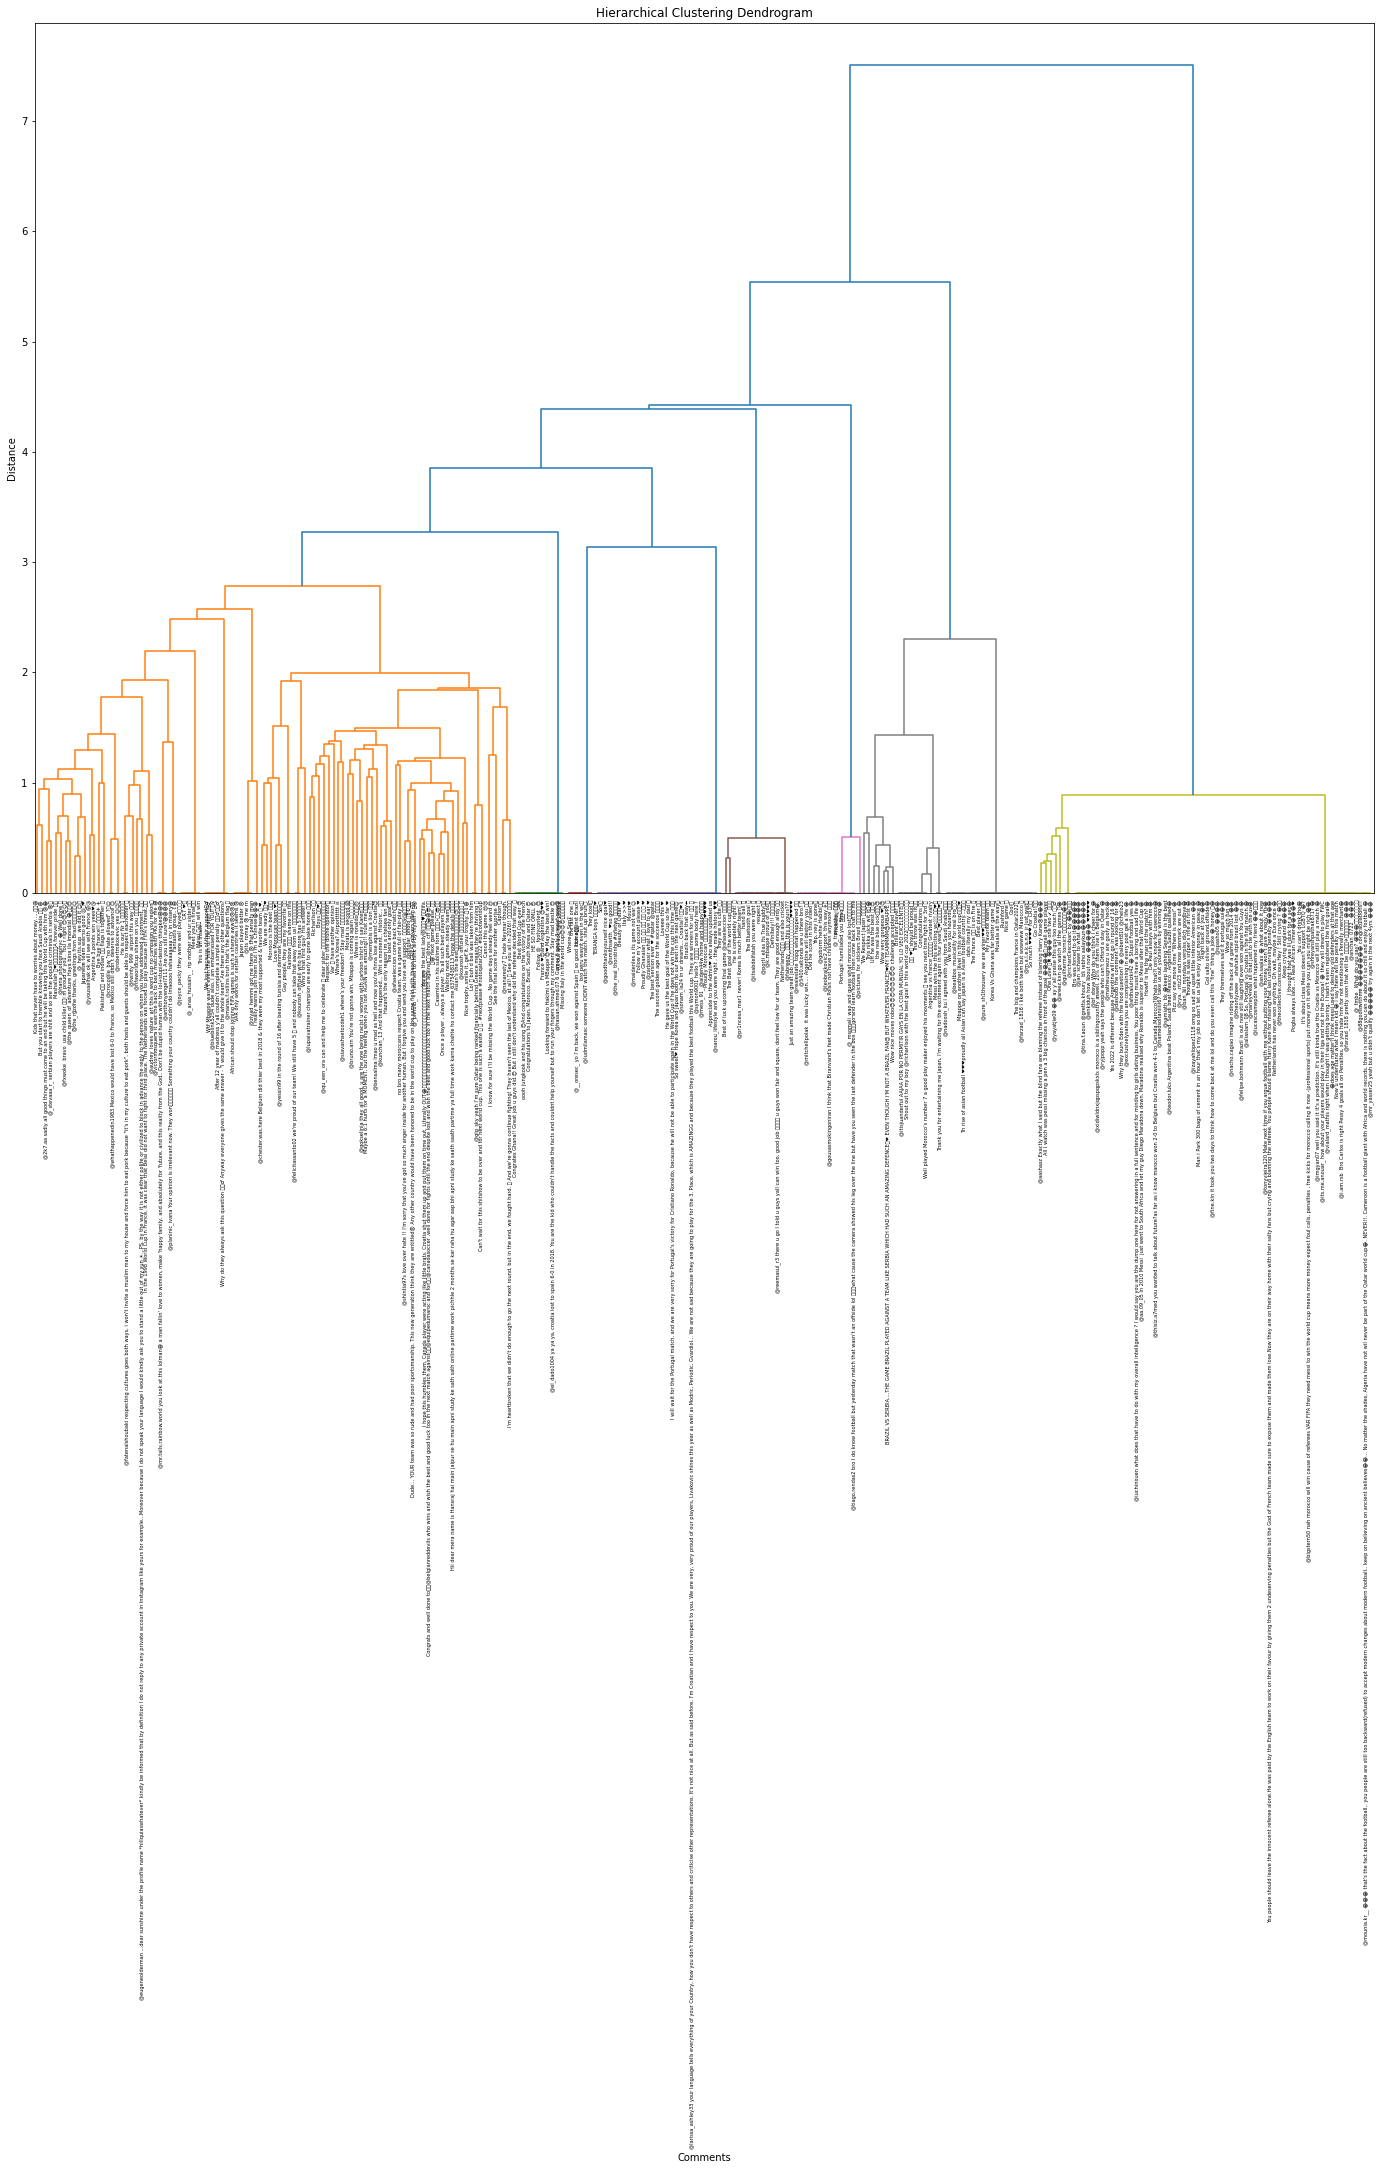

In [45]:
# Hierarchical clustering on text and emoji
en_text_linkage_matrix, en_text_mean_silhouette, en_text_cluster_labels = apply_hierarchical_clustering(en_text_array, en_df)
en_emoji_linkage_matrix, en_emoji_mean_silhouette, en_emoji_cluster_labels = apply_hierarchical_clustering(en_emoji_array, en_df)

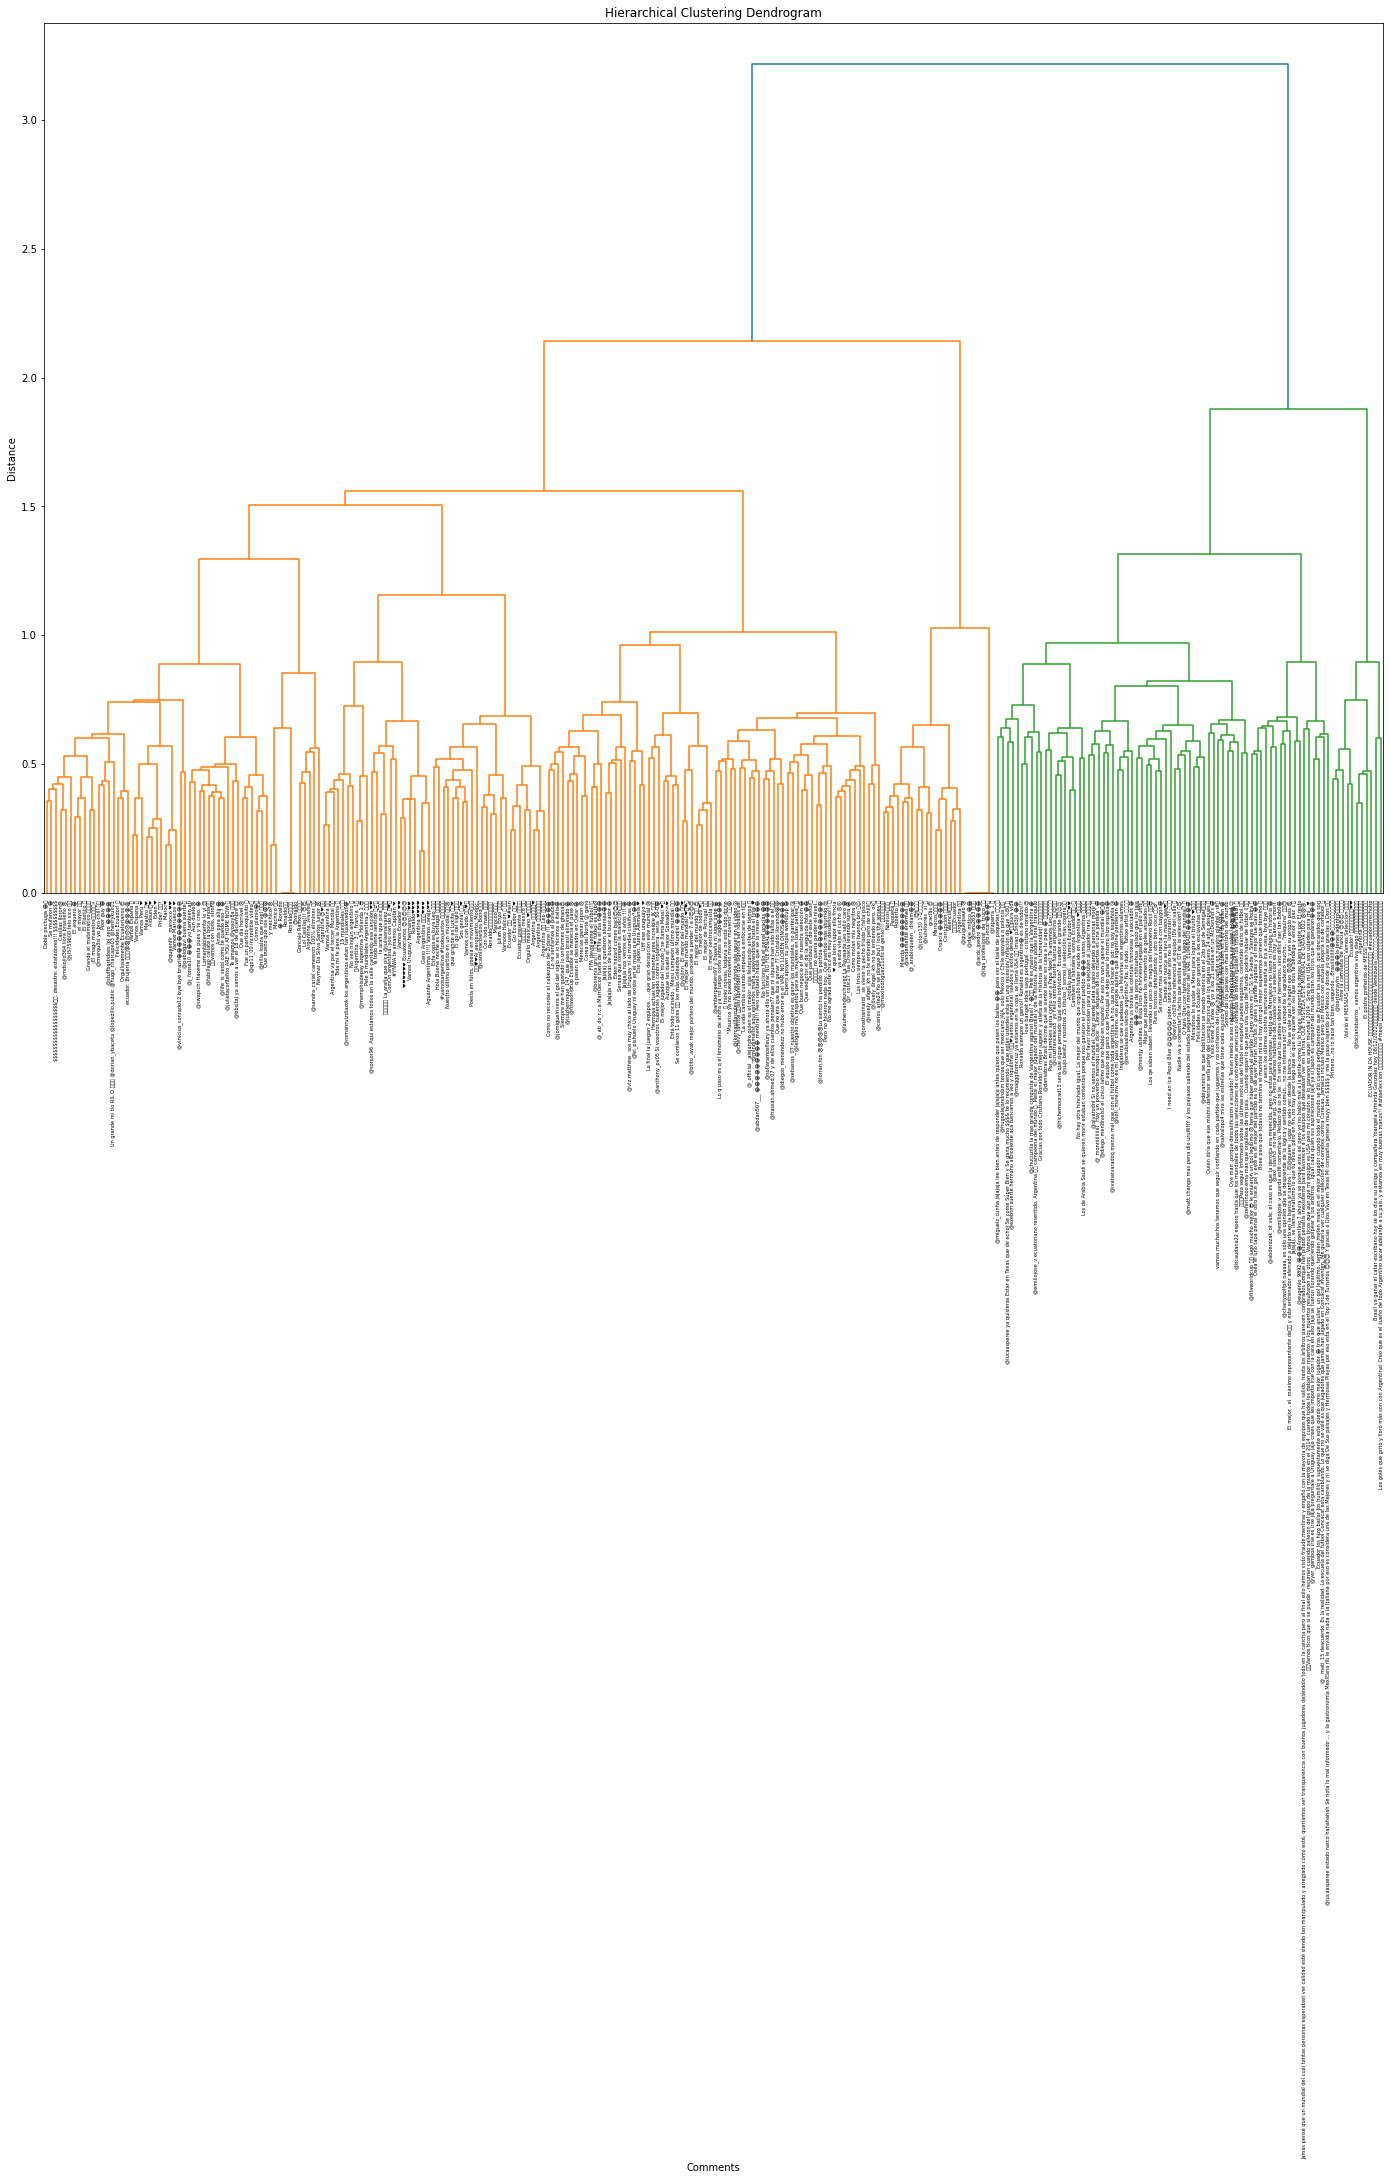

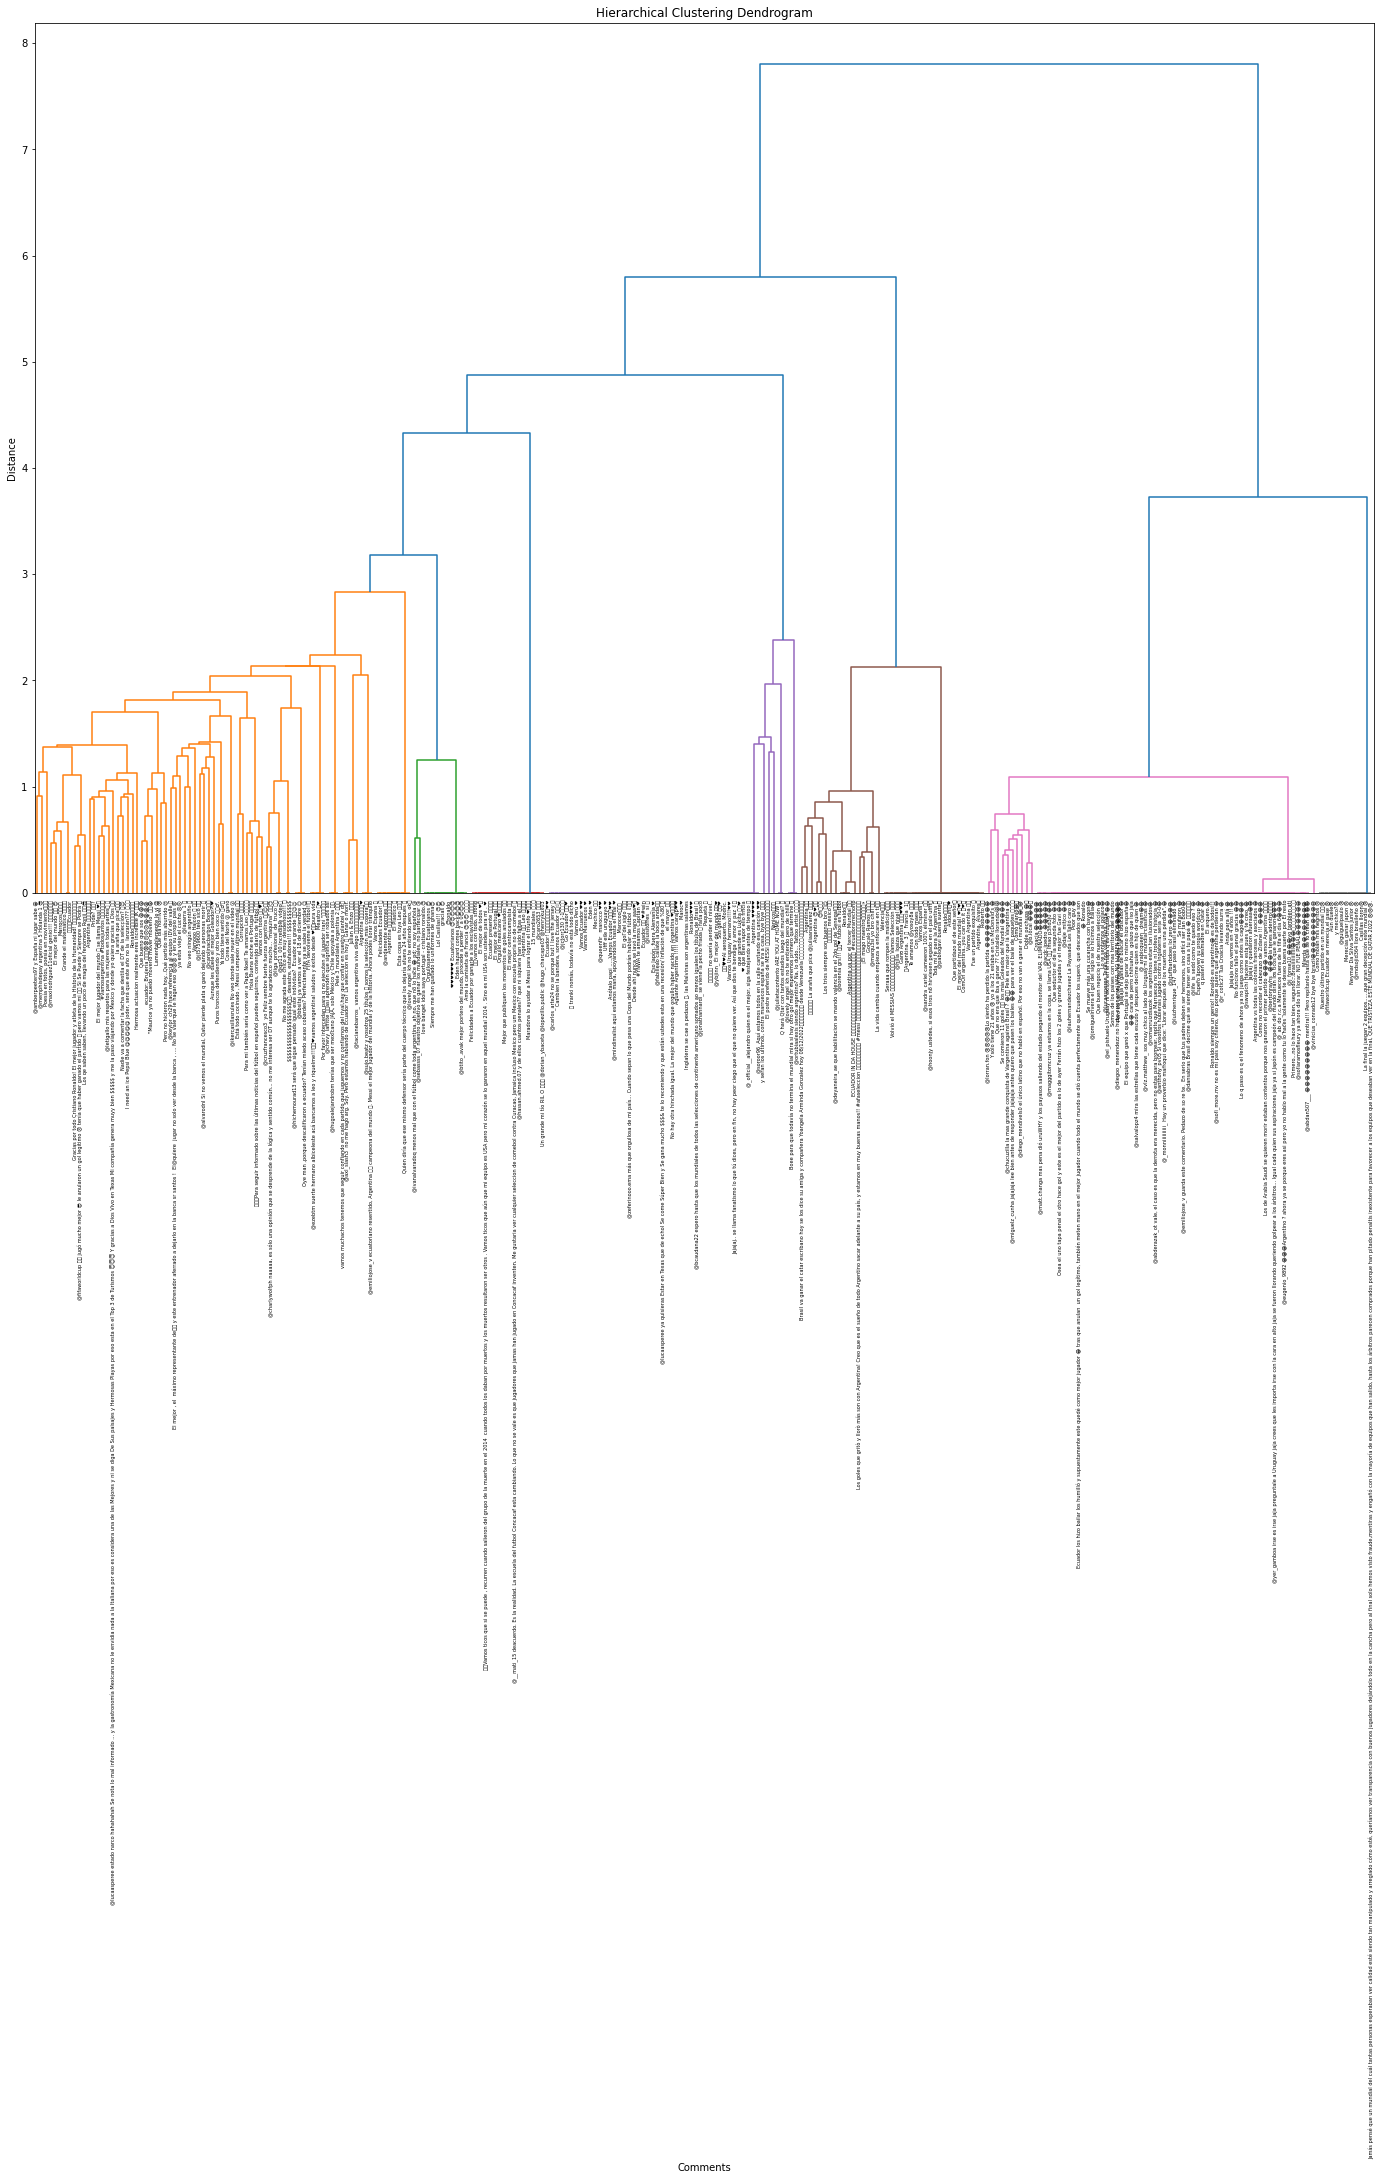

In [46]:
es_text_linkage_matrix, es_text_mean_silhouette, es_text_cluster_labels = apply_hierarchical_clustering(es_text_array, es_df)
es_emoji_linkage_matrix, es_emoji_mean_silhouette, es_emoji_cluster_labels = apply_hierarchical_clustering(es_emoji_array, es_df)

In [47]:
# Calculate Rand Index
from sklearn.metrics import adjusted_rand_score
def calculate_rand_index(text_cluster_labels, emoji_cluster_labels, cluster_labels):
    print("The rand index between text clustering and emoji clustering is: " + str(adjusted_rand_score(emoji_cluster_labels, text_cluster_labels)))
    print("The rand index between text clustering and both clustering is: " + str(adjusted_rand_score(cluster_labels, text_cluster_labels)))
    print("The rand index between emoji clustering and both clustering is: " + str(adjusted_rand_score(emoji_cluster_labels, cluster_labels)))

In [48]:
# rand index for English
calculate_rand_index(en_text_cluster_labels, en_emoji_cluster_labels, en_cluster_labels)

The rand index between text clustering and emoji clustering is: -0.018491607223596697
The rand index between text clustering and both clustering is: -0.026475108770094655
The rand index between emoji clustering and both clustering is: 0.8479278456366321


In [49]:
# rand index for Spanish
calculate_rand_index(es_text_cluster_labels, es_emoji_cluster_labels, es_cluster_labels)

The rand index between text clustering and emoji clustering is: -0.011212490492568656
The rand index between text clustering and both clustering is: -0.014501487765094044
The rand index between emoji clustering and both clustering is: 0.8659410506569271
